
# Initial codes

In [ ]:
# Libraries
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, Reshape, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from torch.utils.data import DataLoader, Dataset
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model
from sklearn.utils import class_weight
from torchvision import transforms
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
from torch import nn
import pandas as pd
import numpy as np
import torch
import math
import cv2
import os

In [ ]:
# Mounting drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip datasets
zip_paths = {
    'shoes': '/content/drive/MyDrive/shoes.zip',
    'emotions': '/content/drive/MyDrive/emotions.zip',
    'airplanes': '/content/drive/MyDrive/airplanes.zip'
}

for name, zip_path in zip_paths.items():
    os.makedirs(f'/content/drive/MyDrive/{name}', exist_ok=True)
    !unzip -q "$zip_path" -d "/content/$name"

# **1. A.** Initial CNN model
Because dataset is too small we use data augmentation techniques such as flipping, rotations, zoom and etc.

We also rescale the images and load datat from files that unzipped in the cell above.

Also data balancing is used to balance the classes data.

At first, Simple model has 2 conv layers, max pooling with Relu acctivations function and 2 dense layers with dropout 0.3. The output layer has 3 neurons with softmax activation function.

Batch size 32 is chosen with 20 epochs and Cross-Entropy loss.

In [ ]:
img_size = 128
batch_size = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    channel_shift_range=30.0,
    fill_mode='nearest'
)

# Rescale only for Validation Set
valid_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    '/content/shoes/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    '/content/shoes/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Calculate Class Weights for Imbalance Handling
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

model = Sequential([
    Conv2D(32, (3,3), kernel_regularizer=l2(0.01), activation='relu', input_shape=(img_size, img_size, 3)),
    Activation('relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=20,
    class_weight=class_weights_dict
)

Found 711 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,706,051 (14.14 MB)

 Trainable params: 3,706,051 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 316ms/step - accuracy: 0.3149 - loss: 1.2084 - val_accuracy: 0.4062 - val_loss: 1.1469
Epoch 2/20
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4062 - loss: 1.1636

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4062 - loss: 1.1636 - val_accuracy: 0.2778 - val_loss: 1.2266
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.3298 - loss: 1.1668 - val_accuracy: 0.4167 - val_loss: 1.1464
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.3125 - loss: 1.1637 - val_accuracy: 0.3333 - val_loss: 1.1513
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.3479 - loss: 1.1447 - val_accuracy: 0.3958 - val_loss: 1.1410
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3125 - loss: 1.1385 - val_accuracy: 0.2778 - val_loss: 1.1500
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - accuracy: 0.3760 - loss: 1.1449 - val_accuracy: 0.3333 - val_loss: 1.1411
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3750 - loss: 1.1344 - val_accuracy: 0.3889 - val_loss: 1.1295
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.3657 - loss: 1.1393 - val_accuracy: 0.4271 - val_loss:

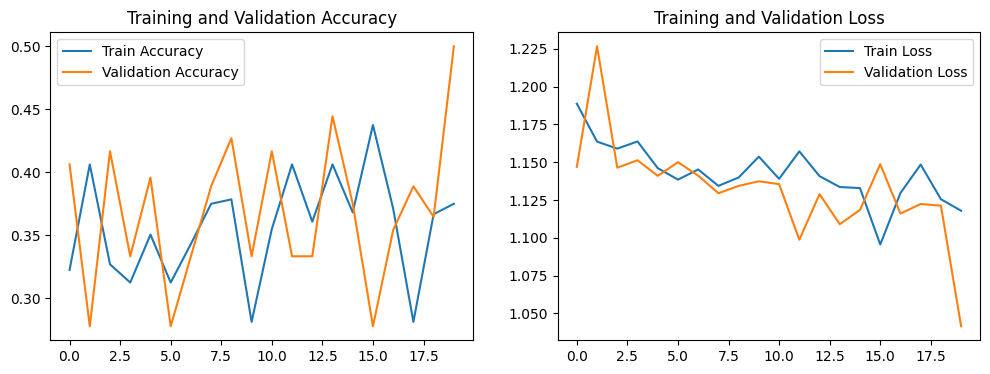

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4054 - loss: 1.1015
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Confusion Matrix
[[ 0 20 18]
 [ 0 22 16]
 [ 0 26 12]]
Classification Report
              precision    recall  f1-score   support

      adidas       0.00      0.00      0.00        38
    converse       0.32      0.58      0.42        38
        nike       0.26      0.32      0.29        38

    accuracy                           0.30       114
   macro avg       0.19      0.30      0.23       114
weighted avg       0.19      0.30      0.23       114



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

val_loss, val_acc = model.evaluate(validation_generator)

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

print('Classification Report')
class_labels = list(train_generator.class_indices.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=class_labels))

# **B.** Testing different hyperparametes
Different hyperparamethers such as learning rate, dropout rate, batch size and filter sized are tested on our model to decide which one has better results.

Overally Batch size 32, learning rate 0.005, dropout rate 0.3 and filter sizes [32, 64, 128, 256] performed better than the others.

In [ ]:
# Define ImageDataGenerator for data augmentation
def get_data_generators(batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1.0/255,           # Normalize images
        shear_range=0.2,           # Apply shear transformation
        zoom_range=0.2,            # Random zoom
        horizontal_flip=True,      # Flip images horizontally
        rotation_range=20          # Add random rotations
    )

    valid_datagen = ImageDataGenerator(rescale=1.0/255)  # Only rescaling for validation/test

    train_generator = train_datagen.flow_from_directory(
        '/content/shoes/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical'
    )

    validation_generator = valid_datagen.flow_from_directory(
        '/content/shoes/test',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, validation_generator

param_grid = {
    'learning_rate': [0.0005, 0.001],
    'dropout_rate': [0.3, 0.4],
    'batch_size': [32, 64],
    'filters': [[32, 64, 128, 256], [64, 128, 256, 256]],
    'activation': ['relu']
}

n_iter = 10  # Number of random samples to test
random_search = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))

def build_model(filters, dropout_rate, learning_rate, activation):
    model = Sequential([
        Conv2D(filters[0], (3,3), activation=activation, input_shape=(img_size, img_size, 3)),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(filters[1], (3,3), activation=activation),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(filters[2], (3,3), activation=activation),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(filters[3], (3,3), activation=activation),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(256, activation=activation),
        Dropout(dropout_rate),
        Dense(128, activation=activation),
        Dropout(dropout_rate),
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

results = []
for i, params in enumerate(random_search):
    print(f"\nTraining model {i+1}/{n_iter}")
    batch_size = params['batch_size']
    train_generator, validation_generator = get_data_generators(batch_size)

    model = build_model(
        filters=params['filters'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        activation=params['activation']
    )

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        epochs=10,
        verbose=1
    )

    val_accuracy = max(history.history['val_accuracy'])
    results.append({**params, 'val_accuracy': val_accuracy})
    print(f"Best Validation Accuracy: {val_accuracy:.4f}")

results_df = pd.DataFrame(results)
print("\nRandom Search Results:")
print(results_df)

best_params = results_df.loc[results_df['val_accuracy'].idxmax()]
print("\nBest Hyperparameters:")
print(best_params)


Training model 1/10
Found 711 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.3719 - loss: 2.3684 - val_accuracy: 0.3021 - val_loss: 1.2192
Epoch 2/10
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3750 - loss: 1.8153

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3750 - loss: 1.8153 - val_accuracy: 0.5000 - val_loss: 0.9951
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.4365 - loss: 1.5061 - val_accuracy: 0.3021 - val_loss: 2.3302
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.2857 - loss: 2.0725 - val_accuracy: 0.5000 - val_loss: 1.6693
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.4274 - loss: 1.3249 - val_accuracy: 0.3229 - val_loss: 2.9494
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3125 - loss: 1.5552 - val_accuracy: 0.3889 - val_loss: 2.4931
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.4620 - loss: 1.2620 - val_accuracy: 0.3125 - val_loss: 2.5678
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - accuracy: 0.4688 - loss: 1.1204 - val_accuracy: 0.4444 - val_loss: 1.7053
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.4683 - loss: 1.1599 - val_accuracy: 0.3333 - val_lo

# **C.** Final Optimzed model
The final optimiezed model has backbone of imagenet pretrained network with trainable layers and another leayers to reduce overfitting.

It also has early stopping and with dropout rate 0.3 and batch size 32.

Epoch number is 60 due to GPU resource but it can be more.

These hyperparamethers are chosen because of the random search done in the cell above.

In [ ]:
img_size = 240  # Match the input layer dimensions
batch_size = 32

# Data generators for training and validation datasets
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True
)

valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255
)

train_dataset = train_datagen.flow_from_directory(
    '/content/shoes/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse',  # Match loss function (sparse_categorical_crossentropy)
    shuffle=True
)

valid_dataset = valid_datagen.flow_from_directory(
    '/content/shoes/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

# Base model: Xception with ImageNet weights
base_model = keras.applications.xception.Xception(
    input_shape=(224, 224, 3), weights='imagenet', include_top=False
)

# Input layer
input = keras.layers.Input(shape=(240, 240, 3))

# Resize and preprocess input images
resized_input = keras.layers.Resizing(224, 224)(input)
preprocessed_input = keras.applications.xception.preprocess_input(resized_input)

# Data augmentation
flip = keras.layers.RandomFlip('horizontal')(preprocessed_input)
rotation = keras.layers.RandomRotation(0.2)(flip)
zoom = keras.layers.RandomZoom(0.2)(rotation)

# Pass through base model
base_model_output = base_model(zoom)

# Add layers to reduce overfitting
avg = keras.layers.GlobalAveragePooling2D()(base_model_output)
dropout = keras.layers.Dropout(0.2)(avg)

# Fully connected layer for 3 classes
output = keras.layers.Dense(3, activation='softmax')(dropout)
model = keras.Model(inputs=input, outputs=output)

# unfreeze pretrained layers
for layer in base_model.layers:
    layer.trainable = True

# Early stopping callback
early_stopping_callback = keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)

optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=60,
                     validation_data=valid_dataset,
                     callbacks=[early_stopping_callback])

Found 711 images belonging to 3 classes.
Found 114 images belonging to 3 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.2883 - loss: 1.1393 - val_accuracy: 0.3246 - val_loss: 1.1005
Epoch 2/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 741ms/step - accuracy: 0.4406 - loss: 1.0876 - val_accuracy: 0.3246 - val_loss: 1.1013
Epoch 3/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 812ms/step - accuracy: 0.4594 - loss: 1.0553 - val_accuracy: 0.3333 - val_loss: 1.1011
Epoch 4/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 769ms/step - accuracy: 0.4834 - loss: 1.0251 - val_accuracy: 0.3333 - val_loss: 1.0993
Epoch 5/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 815ms/step - accuracy: 0.5584 - loss: 0.9841 - val_accuracy: 0.3246 - val_loss: 1.0999
Epoch 6/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.5939 - loss: 0.9565 - val_accuracy: 0.3333 - val_loss: 1.0993
Epoch 7/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 747ms/step - accuracy: 0.6572 - loss: 0.8986 - val_accuracy: 0.3333 - val_loss: 1.0976
Epoch 8/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 762ms/step - accuracy: 0.6395 - loss: 0.8754 - val_accuracy: 0.3772 -

# **2.**
First we add salt and pepper noises to our dataset and save them to file.

In [ ]:
def add_salt_and_pepper_noise(image, salt_prob=0.1, pepper_prob=0.1):
    noisy_image = image.copy()

    # Add salt noise
    num_salt = np.ceil(salt_prob * image.size)
    coords = [np.random.randint(0, i, int(num_salt)) for i in image.shape]
    noisy_image[tuple(coords)] = 1.0

    # Add pepper noise
    num_pepper = np.ceil(pepper_prob * image.size)
    coords = [np.random.randint(0, i, int(num_pepper)) for i in image.shape]
    noisy_image[tuple(coords)] = 0.0

    return noisy_image

data = pd.read_csv('/content/emotions/fer2013.csv')

# Create output directories
os.makedirs('/content/emotions_original', exist_ok=True)
os.makedirs('/content/emotions_noisy', exist_ok=True)

pixels = data['pixels']

img_size = (48, 48)

for idx, pixel_data in enumerate(pixels):
    # Convert pixel data to 2D image
    img_array = np.array(pixel_data.split(), dtype=np.float32).reshape(img_size) / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension for grayscale

    # Add salt-and-pepper noise
    img_array_noisy = add_salt_and_pepper_noise(img_array[:, :, 0])  # Remove channel dimension for noise function
    img_array_noisy = np.expand_dims(img_array_noisy, axis=-1)  # Add back channel dimension

    original_img = array_to_img(img_array)
    noisy_img = array_to_img(img_array_noisy)

    original_img.save(os.path.join('/content/emotions_original', f"{idx}.png"))
    noisy_img.save(os.path.join('/content/emotions_noisy', f"{idx}.png"))

print('Images saved to:\n/content/emotions_original\n/content/emotions_noisy')

Images saved to:
/content/emotions_original
/content/emotions_noisy


# **A.**

Then We train a CNN neural network with U-net on our dataset with MSE loss function and learning rate 0.001 and 20 epochs by using torch library.

Our model consists of 5 convolutional layer in encdoer and 4 deconvolutional layers in decoder.

Our convolution layers have batch normalization, Relu acctivation function and dropout rate 0.3.



In [ ]:
class NoisyImageDataset(Dataset):
    def __init__(self, original_dir, noisy_dir, transform=None):
        self.original_dir = original_dir
        self.noisy_dir = noisy_dir
        self.transform = transform

        # Collect all file paths from subdirectories
        self.original_images = []
        self.noisy_images = []

        for root, _, files in os.walk(original_dir):
            for file in files:
                self.original_images.append(os.path.join(root, file))

        for root, _, files in os.walk(noisy_dir):
            for file in files:
                self.noisy_images.append(os.path.join(root, file))

        # Ensure both lists are sorted to match files between directories
        self.original_images.sort()
        self.noisy_images.sort()

    def __len__(self):
        return len(self.original_images)

    def __getitem__(self, idx):
        original_path = self.original_images[idx]
        noisy_path = self.noisy_images[idx]

        original = Image.open(original_path).convert("RGB")
        noisy = Image.open(noisy_path).convert("RGB")

        if self.transform:
            original = self.transform(original)
            noisy = self.transform(noisy)

        return noisy, original

class Conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, size=3, padding=1, dropout=0.2, stride=1):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, size, padding=padding),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(dropout),
            nn.BatchNorm2d(out_channels),

            nn.Conv2d(out_channels, out_channels, size, padding=padding, stride=stride),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(dropout),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        x = self.convs(x)
        return x

class DeConv_block(nn.Module):
    def __init__(self, in_channels, out_channels, size=3, padding=1, dropout=0.2):
        super().__init__()
        self.deConv = nn.ConvTranspose2d(in_channels, out_channels, size, padding=1, stride=2, output_padding=1)
        self.convs = Conv_block(out_channels * 2, out_channels, size, padding, dropout)

    def forward(self, x, residual):
        x = self.deConv(x)
        x = torch.cat([x, residual], 1)
        x = self.convs(x)
        return x

class Unet(nn.Module):
    def __init__(self, d=64, out_channels=3, dropout=0.2):
        super().__init__()

        # Unet encoder
        self.conv_blocks = nn.ModuleList([
            Conv_block(3, d, dropout=dropout),
            Conv_block(d, 2 * d, stride=2, dropout=dropout),
            Conv_block(2 * d, 4 * d, stride=2, dropout=dropout),
            Conv_block(4 * d, 8 * d, stride=2, dropout=dropout),
            Conv_block(8 * d, 16 * d, stride=2, dropout=dropout)
        ])

        # Unet decoder
        self.deConv_blocks = nn.ModuleList([
            DeConv_block(16 * d, 8 * d, dropout=dropout),
            DeConv_block(8 * d, 4 * d, dropout=dropout),
            DeConv_block(4 * d, 2 * d, dropout=dropout),
            DeConv_block(2 * d, d, dropout=dropout),
        ])

        self.output_conv = nn.Conv2d(d, out_channels, 3, padding=1)
        self.float()

    def forward(self, x):
        x1 = self.conv_blocks[0](x)
        x2 = self.conv_blocks[1](x1)
        x3 = self.conv_blocks[2](x2)
        x4 = self.conv_blocks[3](x3)
        x5 = self.conv_blocks[4](x4)

        x = self.deConv_blocks[0](x5, x4)
        x = self.deConv_blocks[1](x, x3)
        x = self.deConv_blocks[2](x, x2)
        x = self.deConv_blocks[3](x, x1)

        x = self.output_conv(x)

        return x

model = Unet()
print(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor()
])

train_dataset = NoisyImageDataset('/content/emotions_original', '/content/emotions_noisy', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

validation_dataset = NoisyImageDataset('/content/emotions_original', '/content/emotions_noisy', transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

noisy_train_loader = train_loader
noisy_validation_loader = validation_loader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

if os.path.exists('/content/drive/My Drive/UNET.pt'):
    print('Loading model from /content/drive/My Drive/UNET.pt')
    model.load_state_dict(torch.load('/content/drive/My Drive/UNET.pt', map_location=device))
else:
    print('No saved model found. Training from scratch.')

valid_loss_min = np.Inf
for i in range(2):
    model.train()
    sum_train_mse = 0
    training_steps = 0
    for x, y in tqdm(noisy_train_loader):
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y)

        sum_train_mse += loss.cpu().item()
        training_steps += 1

        loss.backward()
        optimizer.step()

    model.eval()
    sum_valid_mse = 0
    for x, y in tqdm(noisy_validation_loader):
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            output = model(x)
        loss = criterion(output, y)

        valid_loss = loss.cpu().item()
        sum_valid_mse += loss.cpu().item()

    if valid_loss <= valid_loss_min:
        print(f'Loss improved from {valid_loss_min:.6f} to {valid_loss:.6f}. Saving model.')
        torch.save(model.state_dict(), '/content/drive/My Drive/UNET.pt')
        valid_loss_min = valid_loss
    else:
        print(f'Loss did not improve. Best loss: {valid_loss_min:.6f}')

torch.save(model.state_dict(), '/content/drive/My Drive/UNET.pt')
print('Training complete. Final model saved to /content/drive/My Drive/UNET.pt.')

Unet(
  (conv_blocks): ModuleList(
    (0): Conv_block(
      (convs): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.1, inplace=True)
        (2): Dropout(p=0.2, inplace=False)
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): LeakyReLU(negative_slope=0.1, inplace=True)
        (6): Dropout(p=0.2, inplace=False)
        (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Conv_block(
      (convs): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.1, inplace=True)
        (2): Dropout(p=0.2, inplace=False)
        (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Conv2d(128, 128, kernel_s

<ipython-input-17-b2e56df84056>:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/My Drive/UNET.pt', map_location=device))


Loss improved from inf to 0.001560. Saving model.


100%|██████████| 561/561 [01:05<00:00,  8.54it/s]


Loss improved from 0.001560 to 0.001196. Saving model.
Training complete. Final model saved to /content/drive/My Drive/UNET.pt.


# **B**
Now we plot the original image with noise and denoised image to compare and evaluate the model on 10 sample pictures.

As seen below model perfomed good at denoising salt and pepper noise.

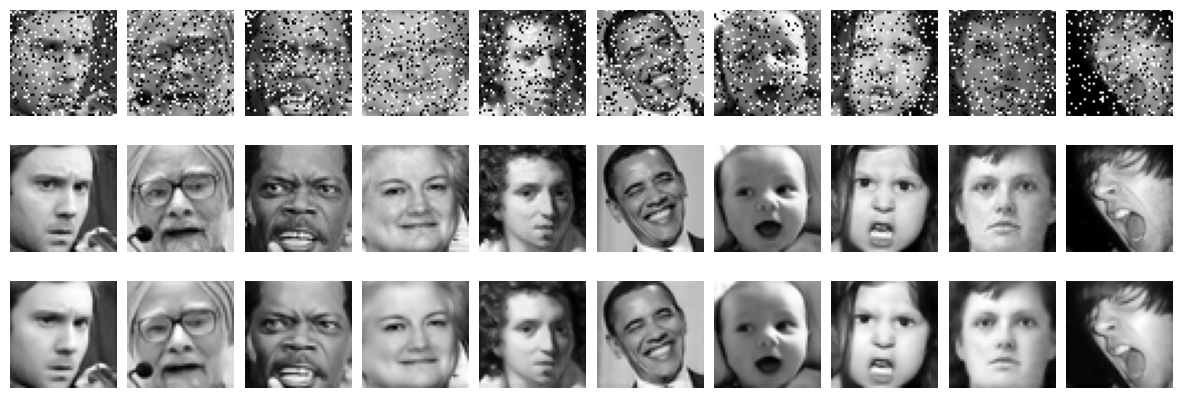

In [ ]:
def load_images_from_directory(directory, target_size=(48, 48)):
    images = []
    filenames = sorted(os.listdir(directory))  # Ensure images are loaded in order
    for file in filenames:
        file_path = os.path.join(directory, file)
        img = load_img(file_path, target_size=target_size, color_mode='rgb')
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1] and ensure single channel
        images.append(img_array)
    return np.array(images)

noisy_images = load_images_from_directory('/content/emotions_noisy')
clean_images = load_images_from_directory('/content/emotions_original')

# Convert to tensor
noisy_images_tensor = torch.tensor(noisy_images, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
noisy_images_tensor = noisy_images_tensor.to(device)

def process_in_batches(model, input_tensor, batch_size=16):
    model.eval()
    outputs = []
    with torch.no_grad():
        for i in range(0, input_tensor.size(0), batch_size):
            batch = input_tensor[i:i+batch_size]
            outputs.append(model(batch).cpu())  # Process batch and move to CPU
    return torch.cat(outputs, dim=0).numpy()  # Concatenate all outputs

batch_size = 64
UNET_denoised_images = process_in_batches(model, noisy_images_tensor, batch_size)[:, 0, :, :] # Use the first channel for visualization

fig = plt.figure(figsize=(15, 5))
for idx in range(10):
    ax = fig.add_subplot(3, 10, idx + 1)
    ax.imshow(noisy_images[idx], cmap='gray')
    ax.axis('off')
    if idx == 0:
        ax.set_ylabel('Noisy', fontsize=16)

    ax = fig.add_subplot(3, 10, idx + 11)
    ax.imshow(clean_images[idx], cmap='gray')
    ax.axis('off')
    if idx == 0:
        ax.set_ylabel('Original', fontsize=16)

    ax = fig.add_subplot(3, 10, idx + 21)
    ax.imshow(UNET_denoised_images[idx], cmap='gray')
    ax.axis('off')
    if idx == 0:
        ax.set_ylabel('Denoised', fontsize=16)

plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

Evaluation out Model with different evaluation metrics such as PSNR, SSIM and MSE.



In [ ]:
psnr_values = []
ssim_values = []
mse_values = []

with torch.no_grad():
    for noisy_batch, clean_batch in noisy_validation_loader:
        noisy_batch = noisy_batch.to(device)
        clean_batch = clean_batch.to(device)

        predicted_images = model(noisy_batch)

        # Move tensors to CPU and convert to NumPy arrays for evaluation
        noisy_batch = noisy_batch.cpu().numpy()
        clean_batch = clean_batch.cpu().numpy()
        predicted_images = predicted_images.cpu().numpy()

        # Compute PSNR, SSIM, and MSE for each image in the batch
        for i in range(len(predicted_images)):
            clean_img = np.transpose(clean_batch[i], (1, 2, 0))  # Convert to HWC format
            predicted_img = np.transpose(predicted_images[i], (1, 2, 0))  # Convert to HWC format

            psnr = peak_signal_noise_ratio(clean_img, predicted_img, data_range=1.0)
            psnr_values.append(psnr)

            ssim = structural_similarity(clean_img, predicted_img, multichannel=True, data_range=1.0, win_size=3)
            ssim_values.append(ssim)

            mse = np.mean((clean_img - predicted_img) ** 2)
            mse_values.append(mse)

print(f'Average MSE: {np.mean(mse_values):.6f}')
print(f'Average PSNR: {np.mean(psnr_values):.2f} dB')
print(f'Average SSIM: {np.mean(ssim_values):.4f}')

Average MSE: 0.001650
Average PSNR: 28.39 dB
Average SSIM: 0.9271


# **3. A**
Selective Search algorithm

In [ ]:
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute intersection area
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute areas of both boxes
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute IoU
    unionArea = boxAArea + boxBArea - interArea
    return interArea / unionArea if unionArea > 0 else 0

def selective_search_regions(image, ground_truth_bboxes, positive_threshold=0.7, negative_threshold=0.3):
    # Simplify and resize image
    resize_width = 500
    scale_factor = resize_width / image.shape[1]
    resized_image = cv2.resize(image, (resize_width, int(image.shape[0] * scale_factor)))

    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(resized_image)
    ss.switchToSelectiveSearchFast()

    # Process proposals
    rects = ss.process()
    rects = rects.tolist()

    rects = [[x, y, w, h] for x, y, w, h in rects]

    # Scale proposals back to original size
    scaled_rects = [
        [int(x / scale_factor), int(y / scale_factor), int(w / scale_factor), int(h / scale_factor)]
        for x, y, w, h in rects
    ]

    regions = []
    labels = []

    for x, y, w, h in scaled_rects:
        if w <= 0 or h <= 0 or x < 0 or y < 0 or x + w > image.shape[1] or y + h > image.shape[0]:
            continue

        proposed_bbox = [x, y, x + w, y + h]
        region = image[y:y + h, x:x + w]

        # Skip small regions
        if region.shape[0] < 32 or region.shape[1] < 32:
            continue

        # Compute IoU with ground truth bounding boxes
        max_iou = 0
        for gt_bbox in ground_truth_bboxes:
            iou = compute_iou(proposed_bbox, gt_bbox)
            max_iou = max(max_iou, iou)

        if max_iou > positive_threshold:
            regions.append(cv2.resize(region, (128, 128)))  # Positive class
            labels.append(1)
        elif max_iou < negative_threshold:
            regions.append(cv2.resize(region, (128, 128)))  # Negative class
            labels.append(0)

    return np.array(regions, dtype=np.float32), np.array(labels, dtype=np.float32)

def non_max_suppression(boxes, scores, iou_threshold):
    indices = []
    boxes = np.array(boxes)
    scores = np.array(scores)

    # Sort by confidence scores in descending order
    sorted_indices = np.argsort(scores)[::-1]

    while len(sorted_indices) > 0:
        # Take the box with the highest score
        current = sorted_indices[0]
        indices.append(current)

        # Calculate IoU with the remaining boxes
        remaining_boxes = boxes[sorted_indices[1:]]
        ious = [compute_iou(boxes[current], box) for box in remaining_boxes]

        # Keep boxes with IoU below the threshold
        sorted_indices = sorted_indices[1:][np.array(ious) <= iou_threshold]

    return indices

def create_model():
    model = Sequential([
        Input(shape=(128, 128, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
images_path = '/content/airplanes/Images/Images'
annotations_path = '/content/airplanes/Airplanes_Annotations/Airplanes_Annotations'

images = []
bboxes = []

for image_name in os.listdir(images_path):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(images_path, image_name)
        image = cv2.imread(image_path)
        if image is not None:
            images.append(image)

            # Process corresponding bounding boxes
            csv_name = os.path.splitext(image_name)[0] + '.csv'
            csv_path = os.path.join(annotations_path, csv_name)
            with open(csv_path, 'r') as file:
                lines = file.readlines()

                # First line: Number of bounding boxes
                num_boxes = int(lines[0].strip())

                # Parse bounding boxes
                image_bboxes = []
                for i in range(1, num_boxes + 1):
                    bbox = list(map(int, lines[i].strip().split()))
                    image_bboxes.append(bbox)

                bboxes.append(image_bboxes)

cropped_regions = []
region_labels = []

for i, image in enumerate(images[:100]):
    if i != 40:
        regions, labels = selective_search_regions(image, bboxes[i])
        cropped_regions.extend(regions)
        region_labels.extend(labels)

cropped_regions = np.array(cropped_regions, dtype=np.float32) / 255.0  # Normalize
region_labels = np.array(region_labels, dtype=np.float32) # Binary labels (0s and 1s)

X_train, X_test, y_train, y_test = train_test_split(cropped_regions, region_labels, test_size=0.2, random_state=42)

In [ ]:
if os.path.exists('airplane_detection_model.keras'):
    model = load_model('airplane_detection_model.keras')
    print('Model loaded from airplane_detection_model.keras')
else:
    model = create_model()
    print('Created a new model')

# Define the checkpoint callback to save the model during training
checkpoint = ModelCheckpoint(
    'airplane_detection_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

model.fit(
    X_train,
    y_train,
    epochs=1,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint]
)

Model loaded from airplane_detection_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9746 - loss: 0.0810
Epoch 1: val_loss improved from inf to 0.05004, saving model to airplane_detection_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 363s 4s/step - accuracy: 0.9746 - loss: 0.0809 - val_accuracy: 0.9845 - val_loss: 0.0500


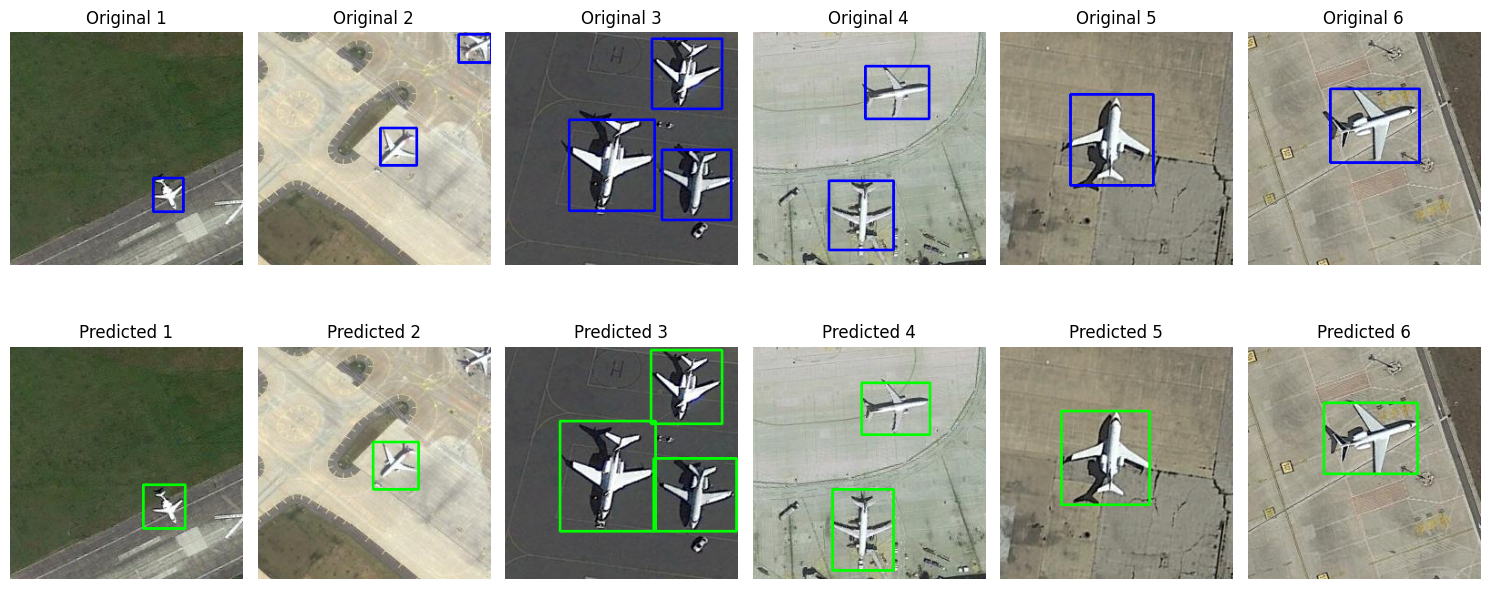

In [ ]:
# Plot first 6 datas form test
test_images = np.array(X_test[:6], dtype=np.float32)
test_bboxes = y_test[:6]
original_images_with_bboxes = []
predicted_images_with_bboxes = []

for idx, (original_image, original_bboxes) in enumerate(zip(test_images, test_bboxes)):
    # Scale and prepare the original image
    original_image = (original_image).clip(0, 255).astype(np.uint8)
    test_image = original_image.copy()

    original_image_with_bboxes = original_image.copy()
    for bbox in original_bboxes:
        x1, y1, x2, y2 = bbox
        cv2.rectangle(original_image_with_bboxes, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue box for ground truth

    # Selective Search
    test_rects = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    test_rects.setBaseImage(test_image)
    test_rects.switchToSelectiveSearchFast()
    rects = test_rects.process()

    proposals = []
    scores = []

    for x, y, w, h in rects:
        if x >= 0 and y >= 0 and x + w <= test_image.shape[1] and y + h <= test_image.shape[0]:
            region = test_image[y:y + h, x:x + w]
            region_resized = cv2.resize(region, (128, 128)) / 255.0
            prediction = model.predict(region_resized[np.newaxis, ...], verbose=0)[0][0]

            if prediction > 0.5:  # Confidence threshold
                proposals.append([x, y, x + w, y + h])
                scores.append(prediction)

    # Apply Non-Maximum Suppression
    if proposals:
        nms_indices = non_max_suppression(proposals, scores, iou_threshold=0.1)
        final_boxes = [proposals[i] for i in nms_indices]

        for box in final_boxes:
            x1, y1, x2, y2 = box
            cv2.rectangle(test_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw only final boxes

    original_images_with_bboxes.append(original_image_with_bboxes)
    predicted_images_with_bboxes.append(test_image)

fig, axes = plt.subplots(2, 6, figsize=(15, 7))
for idx, image in enumerate(original_images_with_bboxes):
    axes[0, idx].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0, idx].axis('off')
    axes[0, idx].set_title(f'Original {idx + 1}')

for idx, image in enumerate(predicted_images_with_bboxes):
    axes[1, idx].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[1, idx].axis('off')
    axes[1, idx].set_title(f'Predicted {idx + 1}')

plt.tight_layout()
plt.show()

In [ ]:
def calculate_average_iou(predictions, ground_truths):
    iou_scores = []

    for pred_box in predictions:
        # Find the ground truth box with the highest IoU for the current predicted box
        best_iou = 0.0
        for gt_box in ground_truths:
            iou = compute_iou(pred_box, gt_box)
            best_iou = max(best_iou, iou)

        iou_scores.append(best_iou)  # Append the best IoU for this prediction

    avg_iou = np.mean(iou_scores) if iou_scores else 0.0
    return avg_iou

all_avg_ious = []

for idx, (original_image, original_bboxes) in enumerate(zip(images[50:60], bboxes[50:60])):
    # Prepare the original image
    test_image = original_image.copy()
    original_image_with_bboxes = original_image.copy()

    # Draw ground truth bounding boxes
    for bbox in original_bboxes:
        x1, y1, x2, y2 = bbox
        cv2.rectangle(original_image_with_bboxes, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue for ground truth

    # Selective Search
    test_rects = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    test_rects.setBaseImage(test_image)
    test_rects.switchToSelectiveSearchFast()
    rects = test_rects.process()

    proposals = []
    scores = []

    # Generate region proposals and get predictions
    for x, y, w, h in rects:
        if x >= 0 and y >= 0 and x + w <= test_image.shape[1] and y + h <= test_image.shape[0]:
            region = test_image[y:y + h, x:x + w]
            region_resized = cv2.resize(region, (128, 128)) / 255.0
            prediction = model.predict(region_resized[np.newaxis, ...], verbose=0)[0][0]

            if prediction > 0.5:  # Confidence threshold
                proposals.append([x, y, x + w, y + h])
                scores.append(prediction)

    # Apply Non-Maximum Suppression
    final_boxes = []
    if proposals:
        nms_indices = non_max_suppression(proposals, scores, iou_threshold=0.1)
        final_boxes = [proposals[i] for i in nms_indices]

    if final_boxes:
        avg_iou = calculate_average_iou(final_boxes, original_bboxes)
        all_avg_ious.append(avg_iou)
    else:
        all_avg_ious.append(0.0)  # No predictions for this image

overall_avg_iou = np.mean(all_avg_ious)
print(f'Average IoU for selective search: {overall_avg_iou:.4f}')

Average IoU for selective search: 0.7669


# **B.**
Edge Boxes algorithm

In [ ]:
# Download pretrained edge boxes model
!wget -O model.yml.gz https://github.com/opencv/opencv_extra/raw/master/testdata/cv/ximgproc/model.yml.gz
!gunzip model.yml.gz

--2024-12-26 10:02:51--  https://github.com/opencv/opencv_extra/raw/master/testdata/cv/ximgproc/model.yml.gz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/cv/ximgproc/model.yml.gz [following]
--2024-12-26 10:02:51--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/cv/ximgproc/model.yml.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6390625 (6.1M) [application/octet-stream]
Saving to: ‘model.yml.gz’

model.yml.gz        100%[===================>]   6.09M  --.-KB/s    in 0.04s   

2024-12-26 10:02:51 (148 MB/s) - ‘model.yml.gz’ saved 

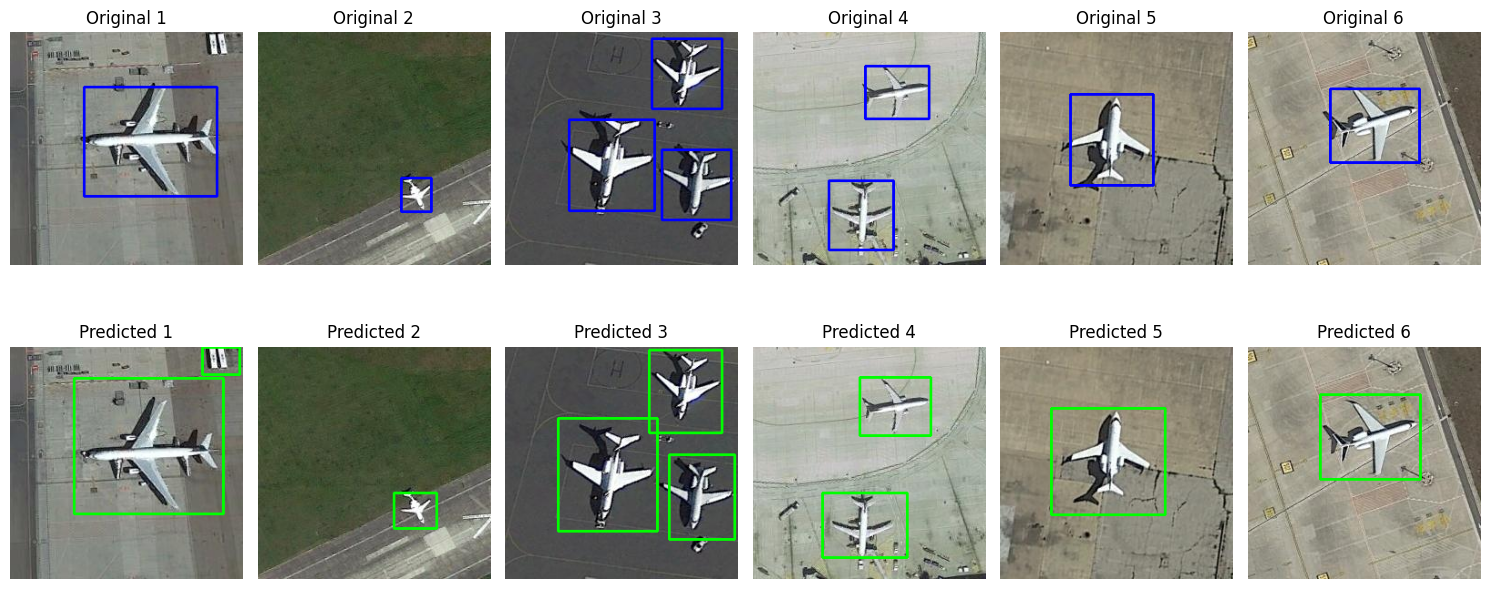

In [ ]:
# Plot first 6 data points from the test set
test_images = np.array(X_test[:6], dtype=np.float32)
test_bboxes = y_test[:6]
original_images_with_bboxes = []
predicted_images_with_bboxes = []

for idx, (original_image, original_bboxes) in enumerate(zip(test_images, test_bboxes)):
    # Scale and prepare the original image
    original_image = (original_image).clip(0, 255).astype(np.uint8)
    test_image = original_image.copy()

    original_image_with_bboxes = original_image.copy()
    for bbox in original_bboxes:
        x1, y1, x2, y2 = bbox
        cv2.rectangle(original_image_with_bboxes, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue box for ground truth

    # Use EdgeBoxes for region proposals
    edge_detector = cv2.ximgproc.createStructuredEdgeDetection('model.yml')
    edges = edge_detector.detectEdges(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0)
    orientation_map = edge_detector.computeOrientation(edges)
    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(100)
    boxes, scores = edge_boxes.getBoundingBoxes(edges, orientation_map)  # Get region proposals and their scores

    proposals = []
    region_scores = []

    for box, score in zip(boxes, scores):
        x, y, w, h = box
        if x >= 0 and y >= 0 and x + w <= test_image.shape[1] and y + h <= test_image.shape[0]:
            region = test_image[y:y + h, x:x + w]
            region_resized = cv2.resize(region, (128, 128)) / 255.0
            prediction = model.predict(region_resized[np.newaxis, ...], verbose=0)[0][0]

            if prediction > 0.5:  # Confidence threshold
                proposals.append([x, y, x + w, y + h])
                region_scores.append(prediction)

    # Apply Non-Maximum Suppression
    if proposals:
        nms_indices = non_max_suppression(proposals, region_scores, iou_threshold=0.1)
        final_boxes = [proposals[i] for i in nms_indices]

        for box in final_boxes:
            x1, y1, x2, y2 = box
            cv2.rectangle(test_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green box for predictions

    original_images_with_bboxes.append(original_image_with_bboxes)
    predicted_images_with_bboxes.append(test_image)

fig, axes = plt.subplots(2, 6, figsize=(15, 7))

for idx, image in enumerate(original_images_with_bboxes):
    axes[0, idx].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0, idx].axis('off')
    axes[0, idx].set_title(f'Original {idx + 1}')

for idx, image in enumerate(predicted_images_with_bboxes):
    axes[1, idx].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[1, idx].axis('off')
    axes[1, idx].set_title(f'Predicted {idx + 1}')

plt.tight_layout()
plt.show()

In [ ]:
all_avg_ious = []

for idx, (original_image, original_bboxes) in enumerate(zip(images[50:60], bboxes[50:60])):
    # Scale and prepare the original image
    original_image = (original_image).clip(0, 255).astype(np.uint8)
    test_image = original_image.copy()

    # Use EdgeBoxes for region proposals
    edge_detector = cv2.ximgproc.createStructuredEdgeDetection('model.yml')
    edges = edge_detector.detectEdges(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0)
    orientation_map = edge_detector.computeOrientation(edges)
    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(100)
    boxes, scores = edge_boxes.getBoundingBoxes(edges, orientation_map)  # Get region proposals and their scores

    proposals = []
    region_scores = []

    # Generate region proposals and get predictions
    for box, score in zip(boxes, scores):
        x, y, w, h = box
        if x >= 0 and y >= 0 and x + w <= test_image.shape[1] and y + h <= test_image.shape[0]:
            region = test_image[y:y + h, x:x + w]
            region_resized = cv2.resize(region, (128, 128)) / 255.0
            prediction = model.predict(region_resized[np.newaxis, ...], verbose=0)[0][0]

            if prediction > 0.5:  # Confidence threshold
                proposals.append([x, y, x + w, y + h])
                region_scores.append(prediction)

    # Apply Non-Maximum Suppression
    final_boxes = []
    if proposals:
        nms_indices = non_max_suppression(proposals, region_scores, iou_threshold=0.1)
        final_boxes = [proposals[i] for i in nms_indices]

    if final_boxes:
        avg_iou = calculate_average_iou(final_boxes, original_bboxes)
        all_avg_ious.append(avg_iou)
    else:
        all_avg_ious.append(0.0)  # No predictions for this image

overall_avg_iou = np.mean(all_avg_ious)
print(f'Average IoU for edge boxes: {overall_avg_iou:.4f}')
print('Average IoU for edge boxes: 0.7523')

Average IoU for edge boxes: 0.7523
